# Final_PJT 

1. 데이터 summary & read
<br></br>
2. EDA
- 고객
  - 고객 state에 따른 분포도
  - 가격별 고객 state 
  - 배송비별 고객 state
  - city에 따른 고객 분포도

- 상품
  - 상관계수
  - 카테고리별 주문 수
  - 지역별 best 상품
  - 카테고리별 상품 수
  - 상품 크기 분포

- 주문
  - 주문별 결제 수단
  - 주문 상태'취소'
  - 일자(년도, 월, 요일, 시간)에 따른 주문건수
  - 지역(state, city)에 따른 주문건수

- 판매
  - state별 판매자 분포
  - 카테고리 판매량
  - seller_id별 상품판매
  - 상품판매에 따른 매출
  - 상품유통서비스세(tax) 와 review_score, price, freight_value, customer_state_code, seller_state_code, customer unique id

- 금액
  - 주문별 결제수단 확인
  - 날짜에 따른 가격변화
  
- 리뷰
  - 리뷰 평점 분포
  - WordCloud
  - review_score기준 데이터 분리 후 N-Gram 분석
  
- 배송
  - order_status를 활용한 분석
  - 배송날짜에 따른 유통과정 date 파악
  - 날짜에 따른 배송상태
  - 배송지역
<br></br>

---

## 1. 데이터 summary 및 read

출처 : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
- 1) olist_customers_dataset
- 2) olist_geolocation_dataset
- 3) olist_order_items_dataset
- 4) olist_order_payments_dataset
- 5) olist_order_reviews_dataset
- 6) olist_orders_dataset
- 7) olist_products_dataset
- 8) olist_sellers_dataset
- 9) product_category_name_translation

### 1) 라이브러리 및 데이터 로드

In [ ]:
#!pip install folium
#!pip install mysql-connector-python
# !pip install pymysql

# !pip install sqlalchemy pymysql

In [278]:
# 라이브러리 로드
import mysql.connector
from sqlalchemy import create_engine, text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import rc
from plotly import tools
import plotly.offline as py
import folium
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

plt.rcParams['axes.unicode_minus'] = False
rc("font", family="Malgun Gothic")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [279]:
olist_customer = pd.read_csv('../dataset/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('../dataset/olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv('../dataset/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('../dataset/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('../dataset/olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv('../dataset/olist_orders_dataset.csv')
olist_products = pd.read_csv('../dataset/olist_products_dataset.csv')
olist_sellers = pd.read_csv('../dataset/olist_sellers_dataset.csv')
olist_products_name_translation = pd.read_csv("../dataset/product_category_name_translation.csv")

In [280]:
# 각 데이터셋의 shape 확인
def shape_each_dataset(df, dataset_name="df"):
    print(f"{dataset_name} 의 데이터는 {df.shape[0]} dataset /  {df.shape[1]} 의 열로 구성")
    
    return df.shape[0], df.shape[1]

In [281]:
customer_r, customer_c = shape_each_dataset(olist_customer, "Olist Customer")
geolocation_r, geolocation_c = shape_each_dataset(olist_geolocation, "Olist Geolocation")
order_items_r, order_items_c = shape_each_dataset(olist_order_items, "Olist Order Items")
order_payments_r, order_payments_c = shape_each_dataset(olist_order_payments, "Olist Order Payments")
order_reviews_r, order_reviews_c = shape_each_dataset(olist_order_reviews, "Olist Order Reviews")
orders_r, orders_c = shape_each_dataset(olist_orders, "Olist Orders")
products_r, products_c = shape_each_dataset(olist_products, "Olist Products")
sellers_r, sellers_c = shape_each_dataset(olist_sellers, "Olist Sellers")

Olist Customer 의 데이터는 99441 dataset /  5 의 열로 구성
Olist Geolocation 의 데이터는 1000163 dataset /  5 의 열로 구성
Olist Order Items 의 데이터는 112650 dataset /  7 의 열로 구성
Olist Order Payments 의 데이터는 103886 dataset /  5 의 열로 구성
Olist Order Reviews 의 데이터는 99224 dataset /  7 의 열로 구성
Olist Orders 의 데이터는 99441 dataset /  8 의 열로 구성
Olist Products 의 데이터는 32951 dataset /  9 의 열로 구성
Olist Sellers 의 데이터는 3095 dataset /  4 의 열로 구성


AWS RDS Database 연결

In [ ]:
# MySQL 연결 정보
host = 'database-1.crtsqbi21zdv.ap-northeast-1.rds.amazonaws.com'
port = 3306
user = 'admin'
password = 'zerobase'
database = 'zerobase'

# 데이터베이스 연결
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}')
conn=engine.connect()


# 데이터 
table_name = ['customer', 'geolocation', 'order_items','order_payments','order_reviews','orders','products','sellers','products_name_translation']
olist_customer.to_sql(name='customer', con=engine, if_exists='replace', index=False)

olist_order_items.to_sql(name='order_items', con=engine, if_exists='replace', index=False)
olist_order_payments.to_sql(name='order_payments', con=engine, if_exists='replace', index=False)
olist_order_reviews.to_sql(name='order_reviews', con=engine, if_exists='replace', index=False)
olist_orders.to_sql(name='orders', con=engine, if_exists='replace', index=False)
olist_products.to_sql(name='products', con=engine, if_exists='replace', index=False)
olist_sellers.to_sql(name='sellers', con=engine, if_exists='replace', index=False)
olist_products_name_translation.to_sql(name='products_name_translation', con=engine, if_exists='replace', index=False)
# olist_geolocation.to_sql(name='geolocation', con=engine, if_exists='replace', index=False)

In [283]:
# https://www.kaggle.com/code/gustavofelici/sql-mining-for-features-to-predict-order-score
# 쿼리문 작성하여 출력

def get_query(query):   
  return pd.read_sql_query(text(query), conn)



In [284]:
# 데이터 확인

query="""
show tables;
"""
    
get_query(query)

,Tables_in_zerobase
0,customer
1,order_items
2,order_payments
3,order_reviews
4,orders
5,products
6,products_name_translation
7,sellers
8,state_tax


In [181]:
datasets = [olist_customer, olist_geolocation, olist_order_items, 
            olist_order_payments,  olist_order_reviews, olist_orders, 
            olist_products, olist_sellers, olist_products_name_translation]

titles = ["customers", "geolocation", "items", "payments", "reviews",
         "orders", "products", "sellers", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='tab20c')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, order_purchase_year, order_purchase_month, order_purchase_day, order_purchase_dayofweek, order_purchase_date, order_purchase_hour, order_purchase_year_month, average_order_purchase_timestamp",99441,16,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


---

## 2. EDA

### 2) 상품 

In [350]:
query="""
SELECT *
FROM customer
INNER JOIN orders ON customer.customer_id = orders.customer_id
INNER JOIN order_reviews ON orders.order_id = order_reviews.order_id
INNER JOIN order_items ON orders.order_id = order_items.order_id
INNER JOIN products ON order_items.product_id = products.product_id
INNER JOIN sellers ON order_items.seller_id = sellers.seller_id 
"""
df_jw=get_query(query)


In [352]:
df_jw=df_jw.loc[:, ~df_jw.columns.duplicated(keep='first')]
# category 포르투갈어 -> 영어
df_jw_1 = df_jw.merge(olist_products_name_translation, on='product_category_name')

#### 카테고리별 주문 수 

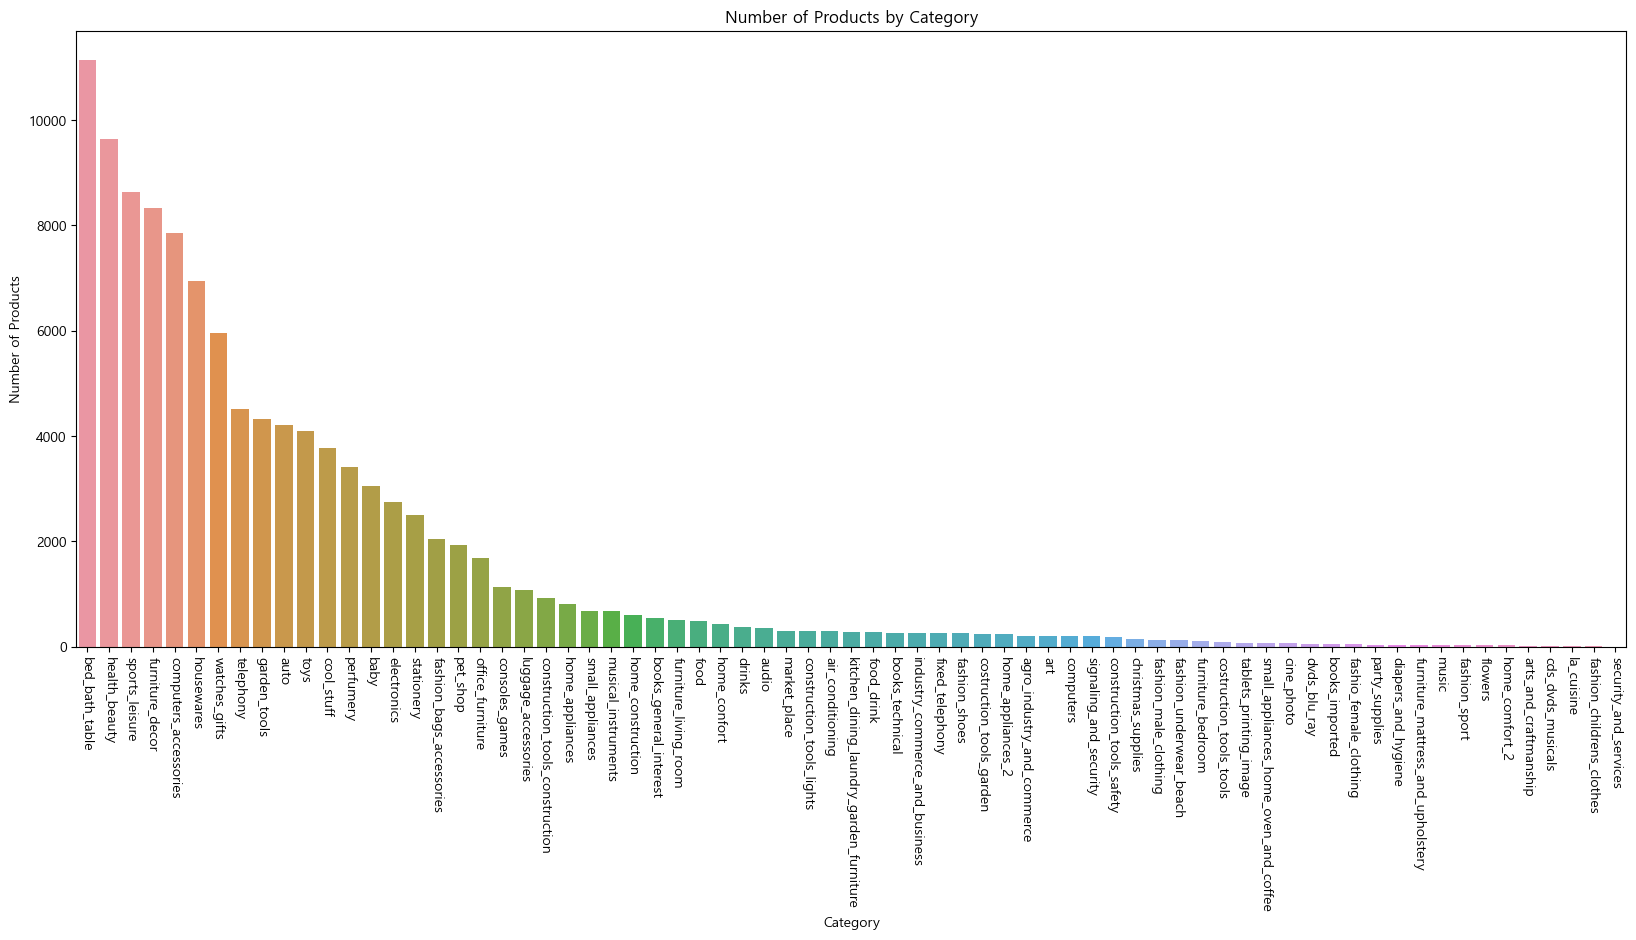

In [353]:
# 카테고리별 주문 개수
cnt=df_jw_1['product_category_name_english'].value_counts()

plt.figure(figsize=(20,8))
plt.title('Number of Products by Category')
sns.countplot(df_jw_1,x='product_category_name_english',order=df_jw_1['product_category_name_english'].value_counts().index)
plt.xticks(rotation=-90)
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.show()


In [203]:
# 새로고침
query="flush privileges;"
conn.execute(text(query))

#### 카테고리별 주문수 TOP10

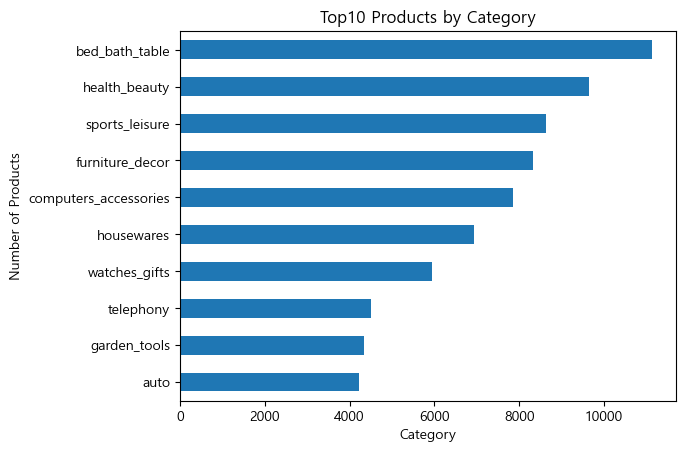

In [354]:
top_10=cnt[:10].sort_values(ascending=True)

top_10.plot(kind='barh')
plt.title('Top10 Products by Category')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.show()

- Top10 : bed_bath_table, sports_leisure, furniture_decor, health_beauty, housewares, auto, computers_accessories, toys, watches_gifts, telophony
- 10개 미만 팔린 제품 : tablets_printing_image, fashion_childrens_clothes, home_comfort_2, security_and_services, cds_dvds_musicals

#### 지역별 상품 best

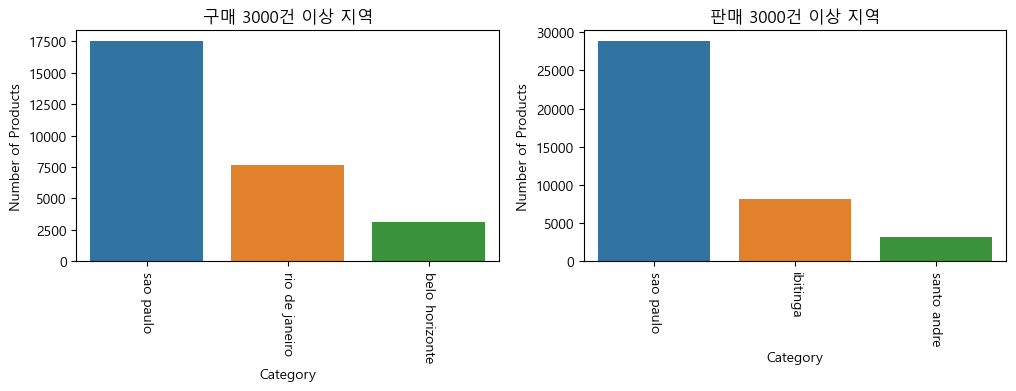

In [355]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plt.title('구매 3000건 이상 지역')
sns.countplot(df_jw_1,x='customer_city',order=df_jw_1.customer_city.value_counts()[:3].index)
plt.xticks(rotation=-90)
plt.xlabel('Category')
plt.ylabel('Number of Products')

plt.subplot(1,2,2)
plt.title('판매 3000건 이상 지역')
sns.countplot(df_merge,x='seller_city',order=df_merge.seller_city.value_counts()[:3].index)
plt.xticks(rotation=-90)
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.show()

- 3000건 이상 구매 : sao paulo , rio de janeiro, belo horizonte
- 3000건 이하 판매 : sao paulo, ibitinga, santo andre 

#### 카테고리별 상품 수

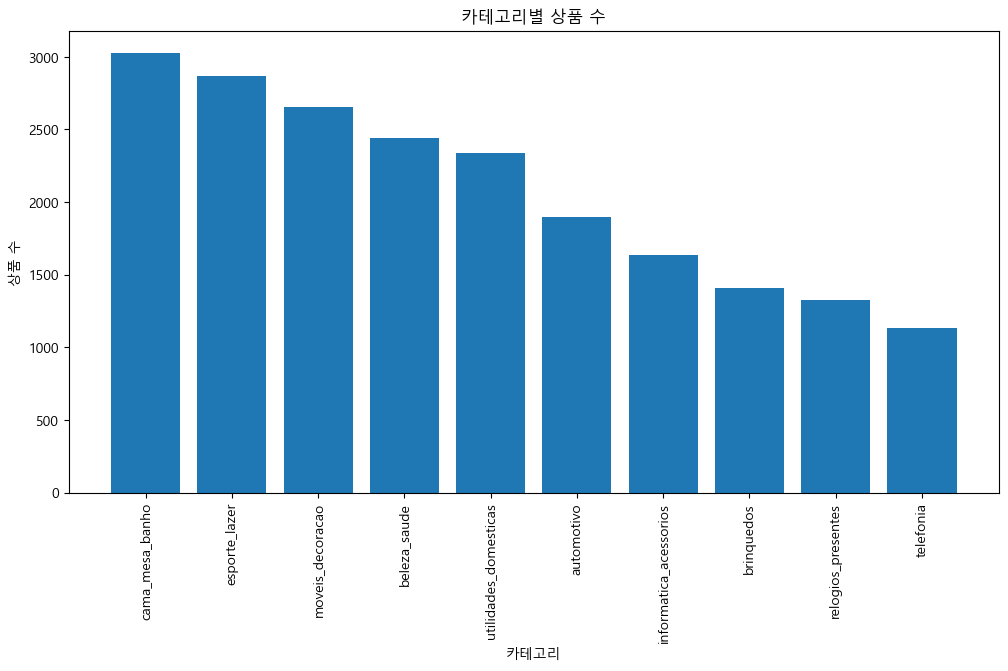

In [356]:
category_counts = olist_products['product_category_name'].value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('카테고리')
plt.ylabel('상품 수')
plt.title('카테고리별 상품 수')
plt.xticks(rotation=90)
plt.show()

#### 상품 크기(부피) 분포

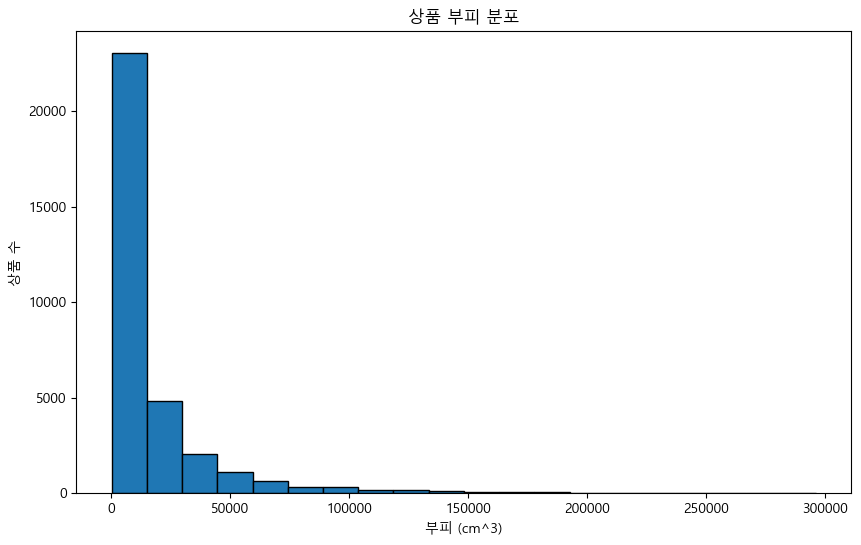

In [357]:
olist_products['product_volume_cm3'] = olist_products['product_length_cm'] * olist_products['product_height_cm'] * olist_products['product_width_cm']

plt.figure(figsize=(10, 6))
plt.hist(olist_products['product_volume_cm3'], bins=20, edgecolor='k')
plt.xlabel('부피 (cm^3)')
plt.ylabel('상품 수')
plt.title('상품 부피 분포')
plt.show()


---

---